In [158]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
from tiny_ta import atr, rsi, sma

# RSI Reversal - Mean Reversal Strategie im S&P 500

Zunächst werden die Kursdaten für den S&P 500 geladen und bereinigt

In [159]:
SYMBOL = "^GSPC"
SYMBOL = "SPY"

stock = yf.download(SYMBOL)

stock = stock[~(stock.High == stock.Low) & ~(stock.Open == stock.Close)]
stock = stock.dropna()

[*********************100%%**********************]  1 of 1 completed


Der VIX für die Volatilität wird als externer Indikator mit betrachtet

In [160]:
vix = yf.download("^VIX")
vix["vix"] = vix["Close"]
stock = pd.merge(
    stock,
    vix[
        [
            "vix",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

[*********************100%%**********************]  1 of 1 completed


Die 5 jährigen Staatsanleihen werden ebenfalls mit betrachtet

In [161]:
yield_5_years = yf.download("^FVX")

yield_5_years["yield_5yr"] = yield_5_years["Close"]
stock = pd.merge(
    stock,
    yield_5_years[
        [
            "yield_5yr",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

[*********************100%%**********************]  1 of 1 completed


Ein paar Indikatoren für spätere Auswertungen

In [162]:
def internal_bar_strength(df: pd.DataFrame) -> pd.Series:
    return (df.Close - df.Low) / (df.High - df.Low)


stock["rsi_3"] = rsi(stock.Close, 3)
stock["rsi_4"] = rsi(stock.Close, 4)
stock["rsi_7"] = rsi(stock.Close, 7)
stock["rsi_10"] = rsi(stock.Close, 10)

stock["atr_10"] = atr(stock, 10, smoothing="rma") / stock.Close * 100

adx_intervall = 21
adx = ta.adx(stock.High, stock.Low, stock.Close, adx_intervall)
stock["adx"] = adx[f"ADX_{adx_intervall}"]
stock["adx_direction"] = np.where(
    adx[f"DMP_{adx_intervall}"] > adx[f"DMN_{adx_intervall}"], 1, -1
)

stock["adx_10"] = ta.adx(stock.High, stock.Low, stock.Close, 10, 10)["ADX_10"]


stock["sma"] = sma(stock.Close, 20)
stock["sma_10"] = sma(stock.Close, 10)
stock["sma_20"] = stock.Close / sma(stock.Close, 20)
stock["sma_50"] = stock.Close / sma(stock.Close, 50)
stock["sma_100"] = stock.Close / sma(stock.Close, 100)
stock["sma_200"] = sma(stock.Close, 200)

stock["sma_pct"] = (stock.Close / stock.sma).round(2)

df = stock

## Jetzt zur Strategie
Sobald der RSI unter ein Limit gefallen ist und der Kurs weiterhin über dem SMA 200 liegt, wird gekauft. Die Position wird verkauft, wenn der Kurs wieder über dem SMA 10 ist.

In [163]:
from backtesting import Strategy


class rsi_reversal(Strategy):
    """
    strategy for trend_trading
    """

    rsi_min = 30

    def ohlc(self, pos=-1) -> tuple:
        """
        helper function for ohlc data
        """
        return (
            self.data.Open[pos],
            self.data.High[pos],
            self.data.Low[pos],
            self.data.Close[pos],
        )

    def init(self):
        super().init()

        self.sma_200 = self.I(lambda: self.data.sma_200, name="SMA(200)", overlay=True)
        self.sma_10 = self.I(lambda: self.data.sma_10, name="SMA(10)", overlay=True)

        # self.rsi = self.I(lambda: self.data.rsi, name="RSI", overlay=False)
        self.rsi = self.I(lambda: self.data.rsi_4, name="RSI", overlay=False)
        self.atr_10 = self.I(lambda: self.data.atr_10, name="ATR", overlay=False)

        self.vix = self.I(lambda: self.data.vix, name="VIX", overlay=False)
        self.yield_5yr = self.I(
            lambda: self.data.yield_5yr, name="Yield 5", overlay=False
        )

    def next(self):
        # super().next()

        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.pl_pct < -0.04:
                trade.close()

            if trade.is_long:
                if _close > self.sma_10[-1]:
                    trade.close()

        if (self.rsi[-1] < self.rsi_min) and (_close > self.sma_200[-1]):
            self.buy()

In [164]:
from backtesting import Backtest

bt = Backtest(
    df["2012-01-01":],
    rsi_reversal,
    cash=100_000,
    commission=0.002,
    trade_on_close=True,
)
stats = bt.run()
bt.plot(superimpose=False)  # , open_browser=False)
stats

Start                     2012-01-03 00:00:00
End                       2024-04-17 00:00:00
Duration                   4488 days 00:00:00
Exposure Time [%]                   20.006506
Equity Final [$]                151578.381147
Equity Peak [$]                 161828.862721
Return [%]                          51.578381
Buy & Hold Return [%]               295.17255
Return (Ann.) [%]                    3.468525
Volatility (Ann.) [%]                7.410869
Sharpe Ratio                         0.468032
Sortino Ratio                        0.682704
Calmar Ratio                         0.166766
Max. Drawdown [%]                  -20.798743
Avg. Drawdown [%]                   -2.111542
Max. Drawdown Duration     1418 days 00:00:00
Avg. Drawdown Duration       69 days 00:00:00
# Trades                                  108
Win Rate [%]                         79.62963
Best Trade [%]                       2.870146
Worst Trade [%]                     -7.910128
Avg. Trade [%]                    

<Axes: xlabel='EntryTime', ylabel='ReturnPct'>

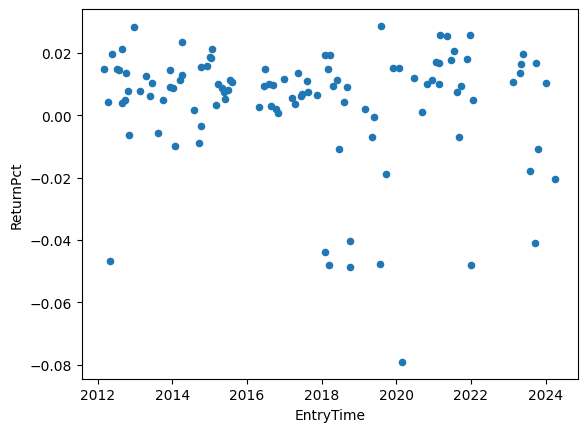

In [165]:
trades = stats["_trades"]
trades.plot.scatter(y="ReturnPct", x="EntryTime")

jetzt wird überprüft welche Tage für die Ein- und Ausstiege besser sein könnten.

In [166]:
stats, heatmap = bt.optimize(
    rsi_min=range(5, 40, 5),
    maximize="Profit Factor",  # "Equity Final [$]",
    max_tries=200,
    random_state=0,
    return_heatmap=True,
)

/Users/produktmanagement/Python/github/backtesting-trading-strategies/.venv/lib/python3.12/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [167]:
# heatmap
heatmap.sort_values().iloc[-5:]

rsi_min
10         1.497424
20         1.506524
35         1.537621
25         1.709327
30         1.795331
Name: Profit Factor, dtype: float64

In [168]:
# heatmap.groupby(["short_days", "lower_ibs", "barsheld"]).mean().unstack()

In [169]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-17 00:00:00
Duration                   4488 days 00:00:00
Exposure Time [%]                   20.006506
Equity Final [$]                151578.381147
Equity Peak [$]                 161828.862721
Return [%]                          51.578381
Buy & Hold Return [%]               295.17255
Return (Ann.) [%]                    3.468525
Volatility (Ann.) [%]                7.410869
Sharpe Ratio                         0.468032
Sortino Ratio                        0.682704
Calmar Ratio                         0.166766
Max. Drawdown [%]                  -20.798743
Avg. Drawdown [%]                   -2.111542
Max. Drawdown Duration     1418 days 00:00:00
Avg. Drawdown Duration       69 days 00:00:00
# Trades                                  108
Win Rate [%]                         79.62963
Best Trade [%]                       2.870146
Worst Trade [%]                     -7.910128
Avg. Trade [%]                    

## The Winner is ...

In [170]:
stats["_strategy"]

<Strategy rsi_reversal(rsi_min=30)>

In [171]:
# bt = Backtest(df["2012-01-01":], end_of_month, cash=100_000, commission=0.002)
stats = bt.run(rsi_min=30)
bt.plot(superimpose=False)  # , open_browser=False)

Row(id='34917', ...)

In [172]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-17 00:00:00
Duration                   4488 days 00:00:00
Exposure Time [%]                   20.006506
Equity Final [$]                151578.381147
Equity Peak [$]                 161828.862721
Return [%]                          51.578381
Buy & Hold Return [%]               295.17255
Return (Ann.) [%]                    3.468525
Volatility (Ann.) [%]                7.410869
Sharpe Ratio                         0.468032
Sortino Ratio                        0.682704
Calmar Ratio                         0.166766
Max. Drawdown [%]                  -20.798743
Avg. Drawdown [%]                   -2.111542
Max. Drawdown Duration     1418 days 00:00:00
Avg. Drawdown Duration       69 days 00:00:00
# Trades                                  108
Win Rate [%]                         79.62963
Best Trade [%]                       2.870146
Worst Trade [%]                     -7.910128
Avg. Trade [%]                    

Die Win Rate beim Trading bezieht sich auf das Verhältnis der Anzahl der gewonnenen Trades zur Gesamtanzahl der Trades. 
Wenn jemand beispielsweise 70% seiner Trades gewinnt, beträgt seine Win Rate 70%.

In [173]:
stats["Win Rate [%]"]

79.62962962962963

Durchschnittlicher Gewinn in Prozent. 
Wie viel Gewinn oder Verlust wurden im Durchschnitt pro Trade erzielt.

In [174]:
stats["Avg. Trade [%]"]

0.4016611044667995

Der Profit-Faktor stellt die Verhältnisse zwischen Gewinnen und Verlusten dar.
Der Profit-Faktor wird berechnet, indem die Summe aller Profite (Gewinne) durch die Summe aller Verluste (einschließlich Gebühren und Kommissionen) für den gesamten Handelszeitraum geteilt wird.
Ein Profit-Faktor größer als 1 zeigt an, dass die Strategie profitabel ist. Je höher der Wert, desto besser.

Ein guter Profit-Faktor liegt normalerweise zwischen 1,75 und 41.
Ein Wert über 1,75 zeigt eine solide Strategie an, während Werte über 4 außergewöhnlich gut sind.

In [175]:
stats["Profit Factor"]

1.7953309974366831

In [176]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)

In [177]:
# merged.set_index('EntryTime')
monthly = pd.DataFrame(merged.groupby(merged.EntryTime.dt.month).ReturnPct.sum())
# global skip_month
skip_month = monthly[monthly["ReturnPct"] < 0.05].index.to_list()
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.0532
2,-0.0415
3,0.0676
4,0.0692
5,0.0813
6,0.0778
7,0.0689
8,0.0232
9,0.0285


<Axes: title={'center': 'Gewinner Trades'}>

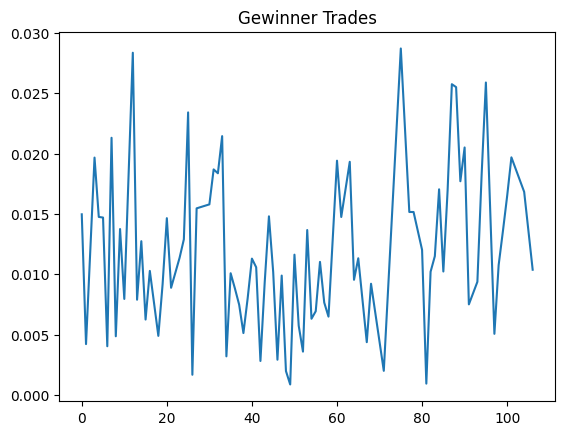

In [178]:
merged[merged.PnL > 0].ReturnPct.plot(title="Gewinner Trades")

<Axes: title={'center': 'Verlierer Trades'}>

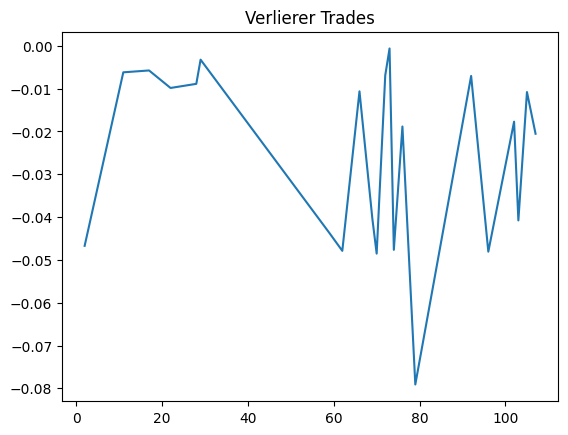

In [179]:
merged[merged.PnL < 0].ReturnPct.plot(title="Verlierer Trades")

In [180]:
df

,Open,High,Low,Close,Adj Close,Volume,vix,yield_5yr,rsi_3,rsi_4,...,adx,adx_direction,adx_10,sma,sma_10,sma_20,sma_50,sma_100,sma_200,sma_pct
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.763752,1003200,12.420000,5.570,NaN,NaN,...,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,43.968750,44.250000,43.968750,44.250000,24.939878,480500,12.330000,5.550,NaN,NaN,...,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-02,44.218750,44.375000,44.125000,44.343750,24.992697,201300,12.250000,5.630,100.0,NaN,...,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.256893,529400,12.120000,5.620,100.0,100.0,...,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.362570,531500,12.290000,5.530,100.0,100.0,...,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-11,515.679993,519.479980,512.080017,518.000000,518.000000,70099000,14.910000,4.623,54.0,52.0,...,19.687082,1,20.357075,518.21,518.51,0.999595,1.017322,1.058872,464.35,1.00
2024-04-12,514.369995,515.820007,509.079987,510.850006,510.850006,92469100,17.309999,4.533,26.0,30.0,...,19.014771,-1,20.947529,518.00,517.29,0.986197,1.002178,1.042977,464.72,0.99
2024-04-15,515.130005,515.299988,503.579987,504.450012,504.450012,92101400,19.230000,4.645,15.0,20.0,...,18.816959,-1,22.939867,517.73,515.52,0.974350,0.989021,1.028776,465.06,0.97


In [181]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-17 00:00:00
Duration                   4488 days 00:00:00
Exposure Time [%]                   20.006506
Equity Final [$]                151578.381147
Equity Peak [$]                 161828.862721
Return [%]                          51.578381
Buy & Hold Return [%]               295.17255
Return (Ann.) [%]                    3.468525
Volatility (Ann.) [%]                7.410869
Sharpe Ratio                         0.468032
Sortino Ratio                        0.682704
Calmar Ratio                         0.166766
Max. Drawdown [%]                  -20.798743
Avg. Drawdown [%]                   -2.111542
Max. Drawdown Duration     1418 days 00:00:00
Avg. Drawdown Duration       69 days 00:00:00
# Trades                                  108
Win Rate [%]                         79.62963
Best Trade [%]                       2.870146
Worst Trade [%]                     -7.910128
Avg. Trade [%]                    

In [182]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.0532
2,-0.0415
3,0.0676
4,0.0692
5,0.0813
6,0.0778
7,0.0689
8,0.0232
9,0.0285


In [183]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.year).PnL.sum().round(1))

,PnL
ExitTime,
2012,6734.5
2013,9772.4
2014,6136.0
2015,15933.2
2016,7460.3
2017,11004.7
2018,-16103.1
2019,-4179.5
2020,-4416.1


In [184]:
equity = stats["_equity_curve"]
equity.groupby(equity.index.year).Equity.last().round(1)

2012    107017.3
2013    116506.9
2014    122642.9
2015    138576.1
2016    146036.4
2017    157041.1
2018    140938.0
2019    136758.5
2020    132342.4
2021    159297.8
2022    152413.7
2023    153378.0
2024    151578.4
Name: Equity, dtype: float64